In [1]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preprocessing

In [2]:
def preprocess_bubble(image):
    pre_processed_image = preprocessing(image)
    original_h, original_w = pre_processed_image.shape[:2]
    target_width = 1000
    scale = target_width / float(original_w)
    target_height = int(original_h * scale)
    image_resized = cv2.resize(pre_processed_image, (target_width, target_height))
    return image_resized

(1280, 853, 3)
(1355, 1000)


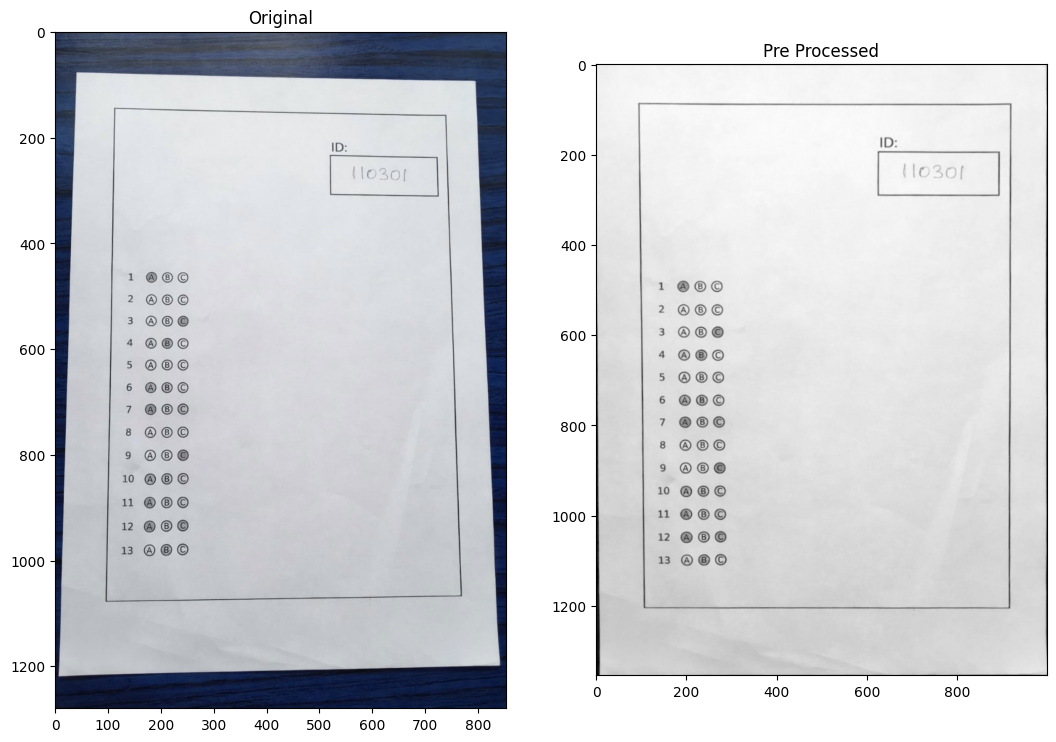

In [3]:
# image = cv2.imread("./Bubble_Sheet_Dataset/1/ID2Q13CH3-20220106T190109Z-001/ID2Q13CH3/IMG_6233.JPG")
image = cv2.imread("./Bubble_Sheet_Dataset/4/modified_2_id.jpeg")
print(image.shape)
pre_processed_image = preprocess_bubble(image)
print(pre_processed_image.shape)
show_images([image, pre_processed_image], ["Original", "Pre Processed"])

## Extract Bubbles 

In [4]:
def find_bubbles(image_gray):
    """
    Detects bubbles in a grayscale image and returns them grouped by rows.
    This approach is generic and handles different numbers of questions/choices.
    """
    # convert the gray image (0 -> 1) to uint8 type and multiply by 255 becuase adaptiveThreshold function
    # deals with this type
    img_uint8 = (image_gray * 255).astype(np.uint8) if image_gray.dtype != np.uint8 else image_resized
    
    # get the binary image image because findCountours deals with binary only
    # we chose the invesrsed binary threshold because this is the type expected by findContours function
    _, binary_image = cv2.threshold(img_uint8, 165, 255, cv2.THRESH_BINARY_INV)

    # apply closing to fill the gaps in the circles which are marked.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    show_images([image_gray, binary_image, closed], ['Resized Image', 'Inverse Binary Image', 'Closed Image'])

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    # [[(x1,y1), (x2, y2)], [(x1,y1), (x2, y2)], [(x1,y1), (x2, y2)]]
    # we use RETR_EXTERNAL to only find external boundaries and ignore inner circles in letters like 'd' 
    # and numbers like '9' or '0'
    contours, _ = cv2.findContours(closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)

        # The ratio of the width to the height of the bubble
        # A perfect circle or square has an aspect ratio of 1.0.
        aspect_ratio = w / float(h) 

        ## countour area (number of pixels in this contour)
        area = cv2.contourArea(cnt) 

        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0: continue

        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        
        # Filter based on area and aspect ratio
        if  circularity >= 0.79 and area > 355 and aspect_ratio > 0.9:
            bubbles.append((x, y, w, h, cnt))
            
    if not bubbles:
        return []

    # group the bubbles into rows (Questions)
    # sort bubbles by their top-to-bottom position (y-coordinate)
    bubbles = sorted(bubbles, key=lambda b: b[1])
    
    rows = []
    if bubbles:
        current_row = [bubbles[0]]
        for i in range(1, len(bubbles)):
            # If the current bubble's Y is close to the previous one, it's the same row
            # threshold is roughly half the height of a bubble
            if abs(bubbles[i][1] - current_row[-1][1]) < (bubbles[i][3] / 2):
                current_row.append(bubbles[i])
            else:
                # Sort the completed row by left-to-right (x-coordinate)
                rows.append(sorted(current_row, key=lambda b: b[0]))
                current_row = [bubbles[i]]
        rows.append(sorted(current_row, key=lambda b: b[0]))
        
    return rows, closed

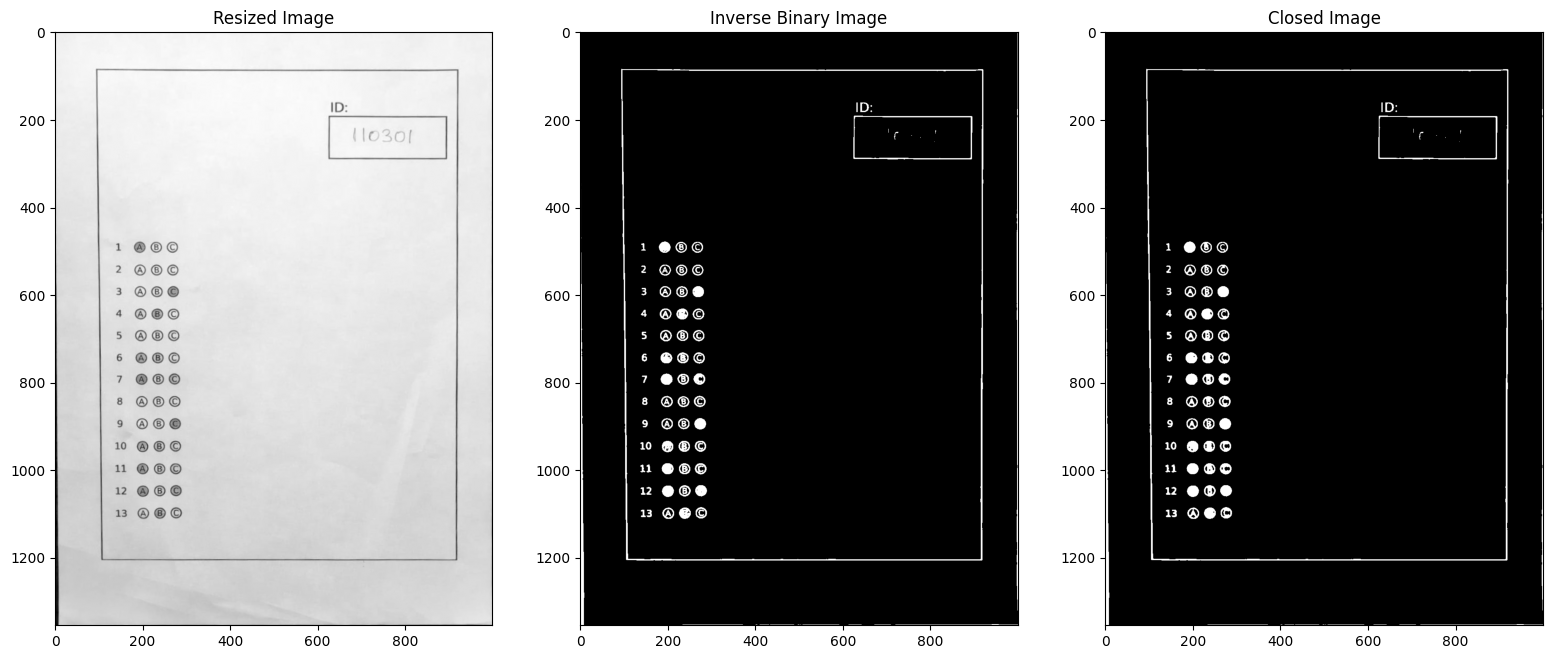

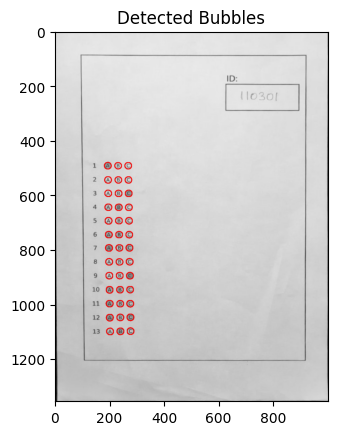

In [5]:
rows, closed = find_bubbles(pre_processed_image)

# Create a copy to draw on (convert grayscale back to RGB so we can draw in color)
viz_image = cv2.cvtColor((pre_processed_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# 3. Loop through the detected rows and bubbles
for row in rows:
    for (x, y, w, h, cnt) in row:
        # Draw a green rectangle around the detected bubble
        # cv2.rectangle(viz_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Optionally draw the actual contour in red
        cv2.drawContours(viz_image, [cnt], -1, (255, 0, 0), 2)

# 4. Show the result
show_images([viz_image], ["Detected Bubbles"])

## Extract ID from box

In [6]:
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys
from io import StringIO
import pandas as pd


# Initialize EasyOCR (only needs to run once)
reader = easyocr.Reader(['en'], gpu=True)
print("EasyOCR initialized successfully!")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR initialized successfully!


Image size: 1000x1355, dtype: uint8


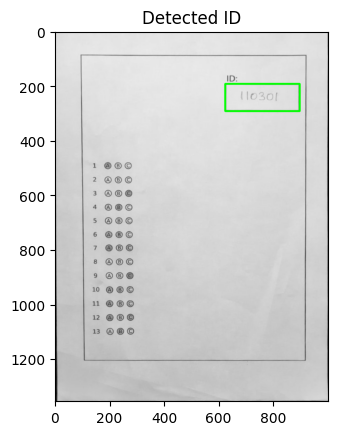

In [7]:
def find_id_text_box(image):
    """
    Finds the ID/Name text box in the warped bubble sheet image.
    Returns the bounding box coordinates (x, y, w, h) and the cropped region.
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Convert to uint8 if it's a float image (0-1 range)
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)
    
    img_h, img_w = gray.shape
    print(f"Image size: {img_w}x{img_h}, dtype: {gray.dtype}")
    
    # Apply adaptive thresholding to find edges/borders
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 41, 10)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    potential_boxes = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)

        area = w * h
        
        area_ratio = area / (img_h * img_w)
        fill_ratio = cv2.contourArea(cnt) / (w * h) if w * h > 0 else 0

        # Aspect ratio between 1.5 and 6 (wider than tall)
        # Area at least 0.3% of image area
        # Located in top 35% of the image
        # Located in the right 70% of the image (ID box is on the right side)
        # The contour should be relatively "filled" (rectangular shape)
        if (1.5 < aspect_ratio < 6.0 and 
            area_ratio > 0.003 and 
            y < (img_h * 0.35) and
            x > (img_w * 0.3) and
            fill_ratio > 0.5):
            potential_boxes.append((x, y, w, h, area))
    
    if not potential_boxes:
        return None, None
    
    # Sort by area (descending) and pick the largest one that fits our criteria
    potential_boxes = sorted(potential_boxes, key=lambda b: b[4], reverse=True)
    
    # Get the best candidate (largest area that meets criteria)
    x, y, w, h, _ = potential_boxes[0]
    
    return (x, y, w, h), gray

# Find the ID text box
box_coords, gray_warped = find_id_text_box(pre_processed_image)

if box_coords:
    x, y, w, h = box_coords
    
    # Draw the detected box on the image
    debug_img = (pre_processed_image * 255).astype(np.uint8) if pre_processed_image.max() <= 1.0 else pre_processed_image.astype(np.uint8)
    debug_img = cv2.cvtColor(debug_img, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 5)
    show_images([debug_img], ['Detected ID'])

else:
    print("Could not find the text box!")

In [43]:
def extract_student_id(image, box_coords, reader):
    """
    extract the student id from the rectangular box using OCR
    """
    x, y, w, h = box_coords
    
    # Convert image to uint8
    if image.dtype != np.uint8:
        img = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    else:
        img = image.copy()
    
    # Crop the text box region with a small margin to remove the border
    margin_h = int(h * 0.1)  # 10% margin on top/bottom
    margin_w = int(w * 0.01)  # 1% margin on left/right
    
    roi = img[y + margin_h : y + h - margin_h, 
              x + margin_w : x + w - margin_w]

    # scale up the image for better OCR
    scale_factor = 3
    roi_scaled = cv2.resize(roi, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    _, binary = cv2.threshold(roi_scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert if text is white on black
    white_pixels = np.sum(binary > 127)
    black_pixels = np.sum(binary <= 127)
    if white_pixels > black_pixels:
        # Text is dark on light background - good for OCR
        ocr_input = binary
    else:
        # Invert - text should be dark on light for better OCR
        ocr_input = cv2.bitwise_not(binary)

    # restrict OCR to digits only to prevent 1 to be read as the letter l 
    DIGITS_ONLY = '0123456789'
        
    # Use width_ths=0.5 to help separate close characters like "11"
    ocr_params = {'allowlist': DIGITS_ONLY, 'width_ths': 0.5, 'paragraph': False}

    results_original = reader.readtext(roi_scaled, **ocr_params)
    results_binary = reader.readtext(ocr_input, **ocr_params)

     # Combine and extract the best result
    all_results = results_original + results_binary
    
    if all_results:
        # Get the text with highest confidence
        best_result = max(all_results, key=lambda r: r[2])
        return best_result[1] 
    else:
        print("No text detected!")
        return None

# Extract the student ID
if box_coords:
    student_id = extract_student_id(pre_processed_image, box_coords, reader)
    print(f"Student ID: {student_id}")
else:
    print("Cannot extract ID - text box not found!")


Student ID: 10301


## Extract Marked Choices from bubble sheet

In [9]:
def get_marked_choices(row_bubbles, closed_image):
    """
    Identifies which bubble in a row is marked based on pixel density.
    """
    if not row_bubbles:
        return []
    
    # ensure image is in the range of 0->1 
    if closed_image.max() > 1.0:
        closed_image = closed_image / 255.0

    # calculate gaps between bubbles to identify question groups
    gaps = []
    for i in range(1, len(row_bubbles)):
        prev_x, prev_y, prev_w, prev_h, _ = row_bubbles[i - 1]
        curr_x, curr_y, curr_w, curr_h, _ = row_bubbles[i]
        # Gap = start of current bubble - end of previous bubble
        gap = curr_x - (prev_x + prev_w)
        gaps.append(gap)
    
    if len(gaps) == 0:
        question_groups = [row_bubbles]
    else:
        sorted_gaps = sorted(gaps)
        median_gap = sorted_gaps[len(sorted_gaps) // 2]
        threshold = median_gap * 2
        
        # group bubbles into questions based on gap threshold
        question_groups = []
        current_group = [row_bubbles[0]]
        
        for i, gap in enumerate(gaps):
            if gap > threshold:
                # a larger gap was detected so we start a new question group
                question_groups.append(current_group)
                current_group = [row_bubbles[i + 1]]
            else:
                # an average gap was detected so we append to the same question group
                current_group.append(row_bubbles[i + 1])
        
        # last group
        question_groups.append(current_group)

    # Threshold for considering a bubble as marked
    MARK_THRESHOLD = 0.88
    
    results = []
    # Find the marked choice(s) for each question group
    for group in question_groups:
        # First pass: calculate density for ALL bubbles in this question
        densities = []
        for i, (x, y, w, h, cnt) in enumerate(group):
            # Create a mask for this specific bubble contour
            mask = np.zeros(closed_image.shape, dtype="uint8")
            cv2.drawContours(mask, [cnt], -1, 255, -1)
            
            # Calculate the average brightness in this area
            # For inverse binary: white (1.0) = marked, black (0) = unmarked
            mask_bool = mask > 0
            mean_val = np.mean(closed_image[mask_bool])
            
            # Higher mean = more white pixels = more likely filled
            densities.append(mean_val)
        
        # Second pass: find ALL bubbles above the threshold
        marked_indices = [i for i, density in enumerate(densities) if density >= MARK_THRESHOLD]
        
        # Return marked indices or -1 if no bubble is marked
        if not marked_indices:
            results.append(-1)
        elif len(marked_indices) == 1:
            results.append(marked_indices[0])  
        else:
            results.append(marked_indices)  
    
    return results

In [ ]:
# Process each row and collect results
all_results = []
for i, row in enumerate(rows):
    row_results = get_marked_choices(row, closed)
    print(f"Row {i}: {row_results}")
    all_results.append(row_results)  # Keep as list of lists

print(f"\nTotal rows: {len(all_results)}")
print(f"Questions per row: {len(all_results[0]) if all_results else 0}")  

Row 0: [0]
Row 1: [-1]
Row 2: [2]
Row 3: [1]
Row 4: [-1]
Row 5: [0]
Row 6: [0]
Row 7: [-1]
Row 8: [2]
Row 9: [[0, 1]]
Row 10: [0]
Row 11: [[0, 2]]
Row 12: [1]

Total rows: 13
Questions per row: 1


In [10]:
# Process each row and collect results
# Use append (not extend) to preserve row structure: [[Q1,Q16,Q31], [Q2,Q17,Q32], ...]
all_results = []
for i, row in enumerate(rows):
    row_results = get_marked_choices(row, closed)
    print(f"Row {i}: {row_results}")
    all_results.append(row_results)  # Keep as list of lists

print(f"\nTotal rows: {len(all_results)}")
print(f"Questions per row: {len(all_results[0]) if all_results else 0}")  

Row 0: [0]
Row 1: [-1]
Row 2: [2]
Row 3: [1]
Row 4: [-1]
Row 5: [0]
Row 6: [0]
Row 7: [-1]
Row 8: [2]
Row 9: [[0, 1]]
Row 10: [0]
Row 11: [[0, 2]]
Row 12: [1]

Total rows: 13
Questions per row: 1


In [ ]:
def reorder_to_sequential(detected_results):
    """
    In case we have multiple question per row,
    this function reorders the detected results to be sequential so that we can compare them 
    easily with the model answer text file    
    """
    if not detected_results:
        return []
    
    # Determine the number of columns (questions per row)
    num_columns = len(detected_results[0]) if detected_results else 0
    num_rows = len(detected_results)
    
    # Reorder: collect all Q's from column 0 first, then column 1, etc.
    sequential = []
    for col in range(num_columns):
        for row in range(num_rows):
            if col < len(detected_results[row]):
                sequential.append(detected_results[row][col])
    
    return sequential

# Test the reordering
print("Original structure (by rows):")
for i, row_result in enumerate(all_results):
    print(f"Row {i}: {row_result}")

sequential_results = reorder_to_sequential(all_results)
print(f"Total questions: {len(sequential_results)}")
print(f"First 10: {sequential_results[:10]}")

Original structure (by rows):
Row 0: [0]
Row 1: [-1]
Row 2: [2]
Row 3: [1]
Row 4: [-1]
Row 5: [0]
Row 6: [0]
Row 7: [-1]
Row 8: [2]
Row 9: [[0, 1]]
Row 10: [0]
Row 11: [[0, 2]]
Row 12: [1]
Total questions: 13
First 10: [0, -1, 2, 1, -1, 0, 0, -1, 2, [0, 1]]


## Read Model Answer and Compare to detected answers

In [32]:
def read_model_answers(file_path):
    """
    Reads model answers from a text file.
    Each line should contain one or more answers.
    """
    answer_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    answers = []
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip().upper()
            if not line:
                continue
            
            # Parse multiple answers (comma or space separated)
            if ',' in line:
                # Comma-separated: "A,B" or "A, B, C"
                parts = [p.strip() for p in line.split(',')]
            else:
                # Single answer
                parts = [line]
            
            # Convert to indices
            indices = [answer_map[p] for p in parts if p in answer_map]
            if indices:
                answers.append(indices if len(indices) > 1 else indices[0])
    
    return answers

In [33]:
       
def grade_answers(detected_answers, model_answers):
    """
    Compares detected answers with model answers and returns grades.
    Handles both single and multiple correct answers.
    """
    results = []
    index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', -1: 'No Answer'}
    
    def to_set(val):
        """Convert answer to a set for comparison."""
        if val == -1:
            return set()
        if isinstance(val, list):
            return set(val)
        return {val}
    
    # Match lengths (use minimum if they differ)
    num_questions = min(len(detected_answers), len(model_answers))
    
    for i in range(num_questions):
        detected = detected_answers[i]
        correct = model_answers[i]
        
        # Convert to sets for comparison
        detected_set = to_set(detected)
        correct_set = to_set(correct)
        
        # Exact match required: detected must exactly match correct
        is_correct = (detected_set == correct_set) and len(detected_set) > 0
        
        points = 1 if is_correct else 0
        
        results.append(points)
    
    return results

## Export Student ID and Grades to Excel

In [30]:
def export_grades_to_excel(student_id, grade_results, output_file="graded_results.xlsx"):
    """
    Exports grading results to an Excel file.
    """    
    num_questions = len(grade_results)

    row = [student_id] + grade_results

    # Create column names dynamically
    columns = ['ID'] + [f'Q{i+1}' for i in range(num_questions)]
    
    # Create DataFrame
    df = pd.DataFrame([row], columns=columns)
    
    # Save to Excel
    df.to_excel(output_file, index=False)
    
    print(f"Results exported to: {output_file}")    
    return df

In [31]:
# Read model answers
model_answers = read_model_answers("model_answer.txt")
print(f"Model answers: {len(model_answers)} questions")

# Grade the student
grades = grade_answers(sequential_results, model_answers)
print(f"Grades: {grades}")

# Export to Excel (single student for now)
# student_id comes from the OCR extraction earlier
df = export_grades_to_excel(student_id, grades, "graded_results.xlsx")

# Display the results
df

Model answers: 13 questions
Grades: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Results exported to: graded_results.xlsx


,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13
0,00301,1,0,1,1,0,1,1,0,1,0,1,1,1


In [46]:
def Module_2(images_folder):
    ## Init OCR 
    reader = easyocr.Reader(['en'], gpu=False)

    ## Load model answer
    model_answers = read_model_answers("./model_answer.txt")
    num_questions = len(model_answers)

    ## Load images from folder
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(images_folder, ext)))
    
    print(f"\nFound {len(image_files)} images in: {images_folder}")
    
    if len(image_files) == 0:
        print("ERROR: No images found!")
        return None
    ## Preprocess images
    all_students_data = []
    
    for i, image_path in enumerate(image_files):
        print(f"\n[{i+1}/{len(image_files)}] Processing: {os.path.basename(image_path)}")
        
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read image")
                continue
            
            # Preprocess
            pre_processed = preprocess_bubble(image)
            # Find bubbles
            rows, closed = find_bubbles(pre_processed)
            
            # Get marked choices for each row
            all_results = []
            for row in rows:
                row_results = get_marked_choices(row, closed)
                all_results.append(row_results)
            
            # Reorder to sequential (Q1, Q2, Q3, ...)
            sequential_results = reorder_to_sequential(all_results)
            print(f"  → Detected {len(sequential_results)} answers")
            
            # Extract student ID
            box_coords, _ = find_id_text_box(pre_processed)
            if box_coords:
                student_id = extract_student_id(pre_processed, box_coords, reader)
            else:
                student_id = "00000"
                        
            # Grade the answers
            grades = grade_answers(sequential_results, model_answers)
            total_score = sum(grades)
            print(f"Score: {total_score}/{num_questions}")
            
            # Append to results
            all_students_data.append((student_id, grades))
            print(f"Done!")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue

    ## Save all results to one excel file
    if not all_students_data:
        print("ERROR: No students processed!")
        return None

    rows_data = []
    for student_id, grades in all_students_data:
        padded_grades = grades + [0] * (num_questions - len(grades))
        row = [student_id] + padded_grades[:num_questions]
        rows_data.append(row)
        columns = ['ID'] + [f'Q{i+1}' for i in range(num_questions)]
        df = pd.DataFrame(rows_data, columns=columns)
        df.to_excel("all_grades.xlsx", index=False)
        return df

In [47]:
results_df = Module_2('./4')

# Display results
results_df

Using CPU. Note: This module is much faster with a GPU.



Found 0 images in: ./4
ERROR: No images found!
